In [309]:
# 使用车流量回归销量，得到残差网络。找出与车流量无关的要素，是否可以解释残差值。
# STEP1：准备数据
# STEP2：使用车流量回归销量，得到线性回归模型
# STEP3：使用模型得到残差值，并打印它与其它要素的关系。

In [310]:
# STEP1：准备数据
import pandas as pd

COLS_DATE = 'date'
COLS_PRICE = '60000305_price'                   #92号国六B
COLS_PRICE_OTHER = '60000305_price_other'
COLS_ORDER_CNT = '60000305_order_cnt'
COLS_AMOUNT = '60000305_amount' 
COLS_LITERS = '60000305_refuelLiters'
# 车流量
COLS_CAR_FLOW_QI = '站前车流量（汽油）'
COLS_CAR_FLOW_CHAI = '站前车流量（柴油）'
COLS_CAR_RATE_QI = '进站率（汽油）'
COLS_CAR_RATE_CHAI = '进站率（柴油）'
COLS_ALL = [COLS_DATE,  COLS_LITERS,
            COLS_PRICE, COLS_PRICE_OTHER, COLS_AMOUNT, COLS_ORDER_CNT,
            COLS_CAR_FLOW_QI, COLS_CAR_FLOW_CHAI,
            COLS_CAR_RATE_QI, COLS_CAR_RATE_CHAI
            ]


# 读取excel文件并获取指定列
df = pd.read_csv('../Data/竞争站分析-竞争站-单站-32801309.csv', usecols=COLS_ALL, encoding='GBK')
print(df.head())

       date  进站率（汽油）  进站率（柴油）  站前车流量（汽油）  站前车流量（柴油）  60000305_price  \
0  2023/1/1     4.50     2.70       3576        668            7.55   
1  2023/1/2     5.73     4.51       3704        820            7.55   
2  2023/1/3     4.78     5.10       4099       1038            7.55   
3  2023/1/4     4.02     4.23       3980       1087            7.75   
4  2023/1/5     4.31     3.44       4246       1106            7.75   

  60000305_price_other  60000305_order_cnt  60000305_refuelLiters  \
0   [5.49, 7.05, 7.55]                 132                3622.58   
1   [5.49, 7.05, 7.55]                 159                4834.58   
2   [5.49, 7.05, 7.55]                 163                4757.30   
3         [5.49, 7.75]                 120                3226.61   
4   [5.49, 7.35, 7.75]                 136                3588.63   

   60000305_amount  
0         27349.85  
1         36700.28  
2         36038.80  
3         25005.75  
4         27828.22  


斜率：216.7814851284836, 截距：-1695.5104410468011


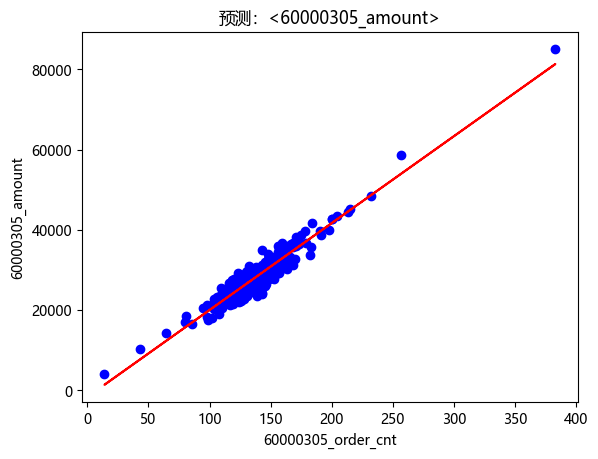

60000305_amount的均方开方误差(RMSE): 1798.64
60000305_amount的平均绝对百分比误差 (MAPE): 0.05


In [311]:
# STEP2：使用车流量回归销量，得到线性回归模型
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 新列：总车流量
df['站前车流量'] = df[COLS_CAR_FLOW_QI] + df[COLS_CAR_FLOW_CHAI]

# 准备数据
COLS_X = COLS_ORDER_CNT
COLS_Y = COLS_AMOUNT
x = df[COLS_X].values.reshape(-1, 1)  # 在liner中，x必须转换为二维数组
y = df[COLS_Y]

# 模型拟合
model = LinearRegression()
model.fit(x,y)
slope = model.coef_[0]
intercept = model.intercept_
print(f"斜率：{slope}, 截距：{intercept}")

# 预测
y_new = model.predict(x)

# 可视化
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 更好的中文字体，可以显示“-”号
plt.scatter(x, y, color = 'blue')
plt.plot(x, model.predict(x), color='red')
plt.title(f"预测：<{COLS_Y}>")
plt.xlabel(COLS_X)
plt.ylabel(COLS_Y)
plt.show()

### 评估 ###
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# 计算均方根误差（RMSE）
mse = mean_squared_error(y, y_new)
rmse = sqrt(mse)
print(f'{COLS_Y}的均方开方误差(RMSE): {rmse:.2f}')
mape = mean_absolute_percentage_error(y, y_new)
print(f'{COLS_Y}的平均绝对百分比误差 (MAPE): {mape:.2f}')

           date  进站率（汽油）  进站率（柴油）  站前车流量（汽油）  站前车流量（柴油）  60000305_price  \
0      2023/1/1     4.50     2.70       3576        668            7.55   
1      2023/1/2     5.73     4.51       3704        820            7.55   
2      2023/1/3     4.78     5.10       4099       1038            7.55   
3      2023/1/4     4.02     4.23       3980       1087            7.75   
4      2023/1/5     4.31     3.44       4246       1106            7.75   
..          ...      ...      ...        ...        ...             ...   
360  2023/12/27     3.31     3.89       6400        951            7.51   
361  2023/12/28     3.53     4.22       7643       1042            7.51   
362  2023/12/29     2.68     3.50       8033       1058            7.51   
363  2023/12/30     3.39     4.51       6718        776            7.51   
364  2023/12/31     3.60     3.28       6164        610            7.51   

     60000305_price_other  60000305_order_cnt  60000305_refuelLiters  \
0                    7.05  

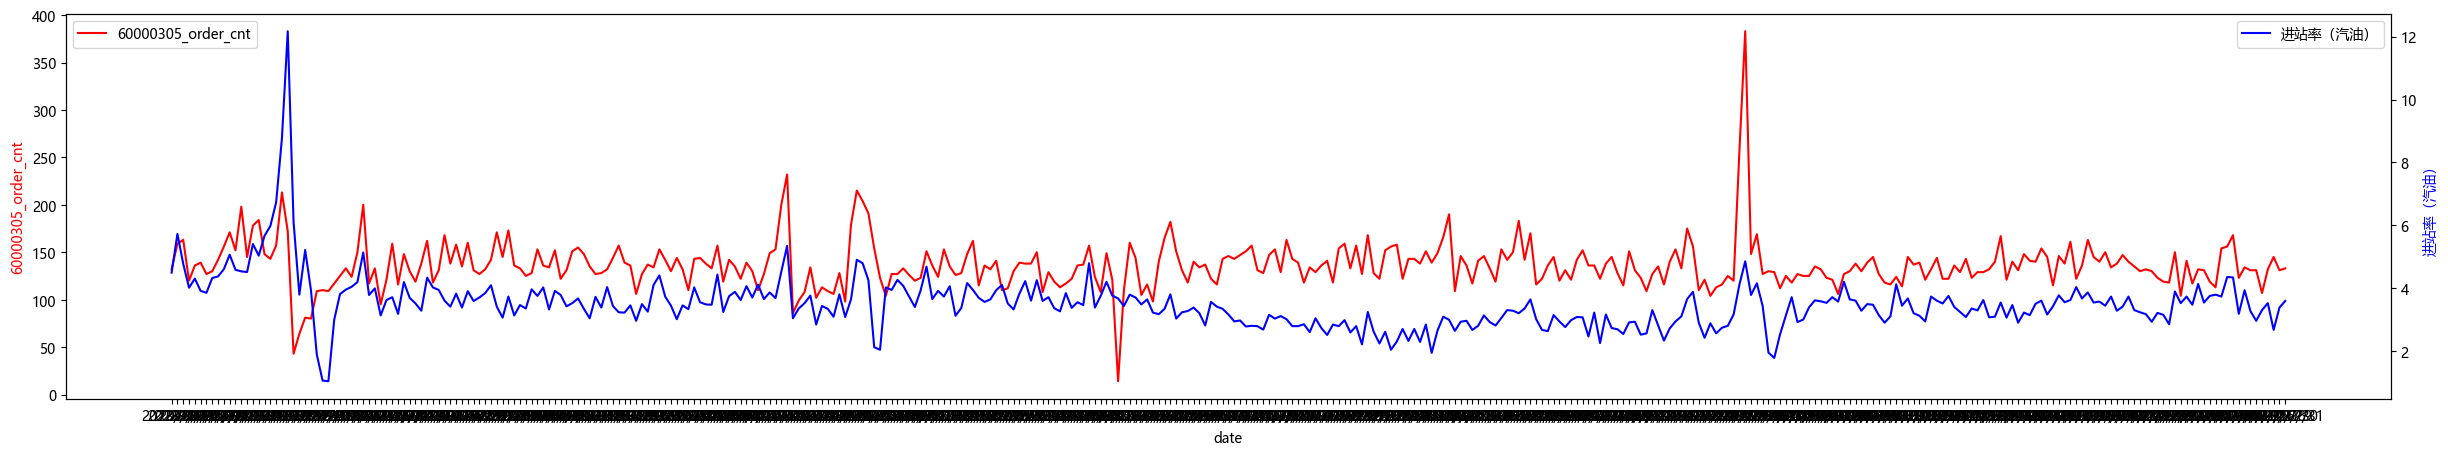

In [312]:
# STEP3：使用模型得到残差值，并打印它与其它要素的关系。
import CompetingStationPrice_Utils as utils

# 新列：竞争站点价格
df[COLS_PRICE_OTHER] = df[COLS_PRICE_OTHER].apply(utils.get_second_lowest_price)
# 新列：当前油品的差价
df['价格差'] = df[COLS_PRICE] - df[COLS_PRICE_OTHER]        # 我们比对方贵为正数， 便宜为负数
# 新列：当前油品的差价
df['平均加油升数'] = df[COLS_LITERS] / df[COLS_ORDER_CNT]
# 新列：当前油品的价差变化
df['价格差变化'] = df['价格差'] - df['价格差'].shift(1)
df['价格差变化'] = df['价格差变化'].fillna(0)
# 新列：当前油品的竞争价格变化
df['竞争站价格变化'] = df[COLS_PRICE_OTHER] - df[COLS_PRICE_OTHER].shift(1)
df['竞争站价格变化'] = df['竞争站价格变化'].fillna(0)
df['价格变化'] = df[COLS_PRICE] - df[COLS_PRICE].shift(1)
df['价格变化'] = df['价格变化'].fillna(0)

# 预测
df['resi'] = df[COLS_Y] - y_new
print(df)

# 可视化
from scipy.stats import pearsonr, spearmanr, kendalltau
COLS_X = COLS_DATE
COLS_Y1 = COLS_ORDER_CNT  # 检验相关性的两列之一
COLS_Y2 = COLS_CAR_RATE_QI   # 检验相关性的两列之二

df_clean = df[[COLS_Y1, COLS_Y2]].dropna()
pearson_corr, pearson_pvalue = pearsonr(df_clean[COLS_Y1], df_clean[COLS_Y2])
spearman_corr, spearman_pvalue = spearmanr(df_clean[COLS_Y1], df_clean[COLS_Y2])
kendall_corr, kendall_pvalue = kendalltau(df_clean[COLS_Y1], df_clean[COLS_Y2])

print(F"{COLS_Y1}与{COLS_Y2}相关系数：")
print(f"Pearson相关系数: {pearson_corr}, p值: {pearson_pvalue}")
print(f"Spearman相关系数: {spearman_corr}, p值: {spearman_pvalue}")
print(f"Kendall相关系数: {kendall_corr}, p值: {kendall_pvalue}")

# 打印折线图
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
fig, ax1 = plt.subplots(figsize=(30,5))

# 绘制第一条曲线
ax1.plot(df[COLS_X], df[COLS_Y1], 'r-', label=COLS_Y1)
ax1.set_xlabel(COLS_X)
ax1.set_ylabel(COLS_Y1, color='r')
ax1.legend(loc='upper left')
# 绘制第二条曲线
ax2 = ax1.twinx()
ax2.plot(df[COLS_X], df[COLS_Y2], 'b-', label=COLS_Y2)
ax2.set_ylabel(COLS_Y2, color='b')
ax2.legend(loc='upper right')

plt.show()